In [84]:
#Examen 2 Temas Selectos de Ingeniería Petrolera
#Profesor: Dra. Rosa Maria Mariscal Romero
#Alumno: Manzano Reséndiz Julio Isaac
#Sentiment Analysis On Reddit Crypto News With Python

#Libraries
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud
from PIL import Image
from pprint import pprint

In [6]:
#NLTK´s databases
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JulioIsaacMR\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JulioIsaacMR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JulioIsaacMR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#Setting up reddit client
r = praw.Reddit(client_id='3CJluzJdZki4r7M499mSKg',
                client_secret='V7JvFmK6vSQGhTIpzM2O_CxxgDWPpg',
                user_agent='Jumper_ju',
                check_for_asyn=False)

In [8]:
#Selecting subreddit and sorting type
l1=100
subreddit = r.subreddit('CryptoMarkets')
news1 = [*subreddit.search('Bitcoin+bitcoin+BTC',sort ='new',limit=l1)] # new post of the day
subreddit = r.subreddit('CryptoCurrency')
news2 = [*subreddit.search('Bitcoin+bitcoin+BTC',sort ='new',limit=l1)] # new post of the day
subreddit = r.subreddit('CryptoCurrencyTrading')
news3 = [*subreddit.search('Bitcoin+bitcoin+BTC',sort ='new',limit=l1)] # new post of the day
subreddit = r.subreddit('Bitcoin')
news4 = [*subreddit.search('Bitcoin+bitcoin+BTC',sort ='new',limit=l1)] # new post of the day
news=news1+news2+news3+news4
print(len(news))

400


In [9]:
news0 = news[0]
#first new printing 
print(news0.title) # headline
print(dt.datetime.fromtimestamp(news0.created)) # date and time

Bitcoin On A Roll! BTC Next target $50,000!
2023-10-24 12:33:53


In [10]:
# create lists of the information from each news
title = [news.title for news in news]
news = pd.DataFrame({
    "title": title,
})
news.head()

,title
0,"Bitcoin On A Roll! BTC Next target $50,000!"
1,Bitcoin 10 Years Ago: Crossing the $1000 mark ...
2,The Bitcoin Company Review 2023: BTC Cashback ...
3,What is the reason for the brutal rise of bitc...
4,I learned to code and built a free crypto anal...


In [71]:
#Sentiment Analysis with VADERR
sid = SentimentIntensityAnalyzer()
res = [*news['title'].apply(sid.polarity_scores)]
pprint(res[0:5])


[{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.4404, 'neg': 0.0, 'neu': 0.734, 'pos': 0.266},
 {'compound': -0.6249, 'neg': 0.272, 'neu': 0.728, 'pos': 0.0},
 {'compound': 0.5106, 'neg': 0.0, 'neu': 0.809, 'pos': 0.191}]


In [12]:
#Joining Data
sentiment_df = pd.DataFrame.from_records(res)
news = pd.concat([news, sentiment_df], axis=1, join='inner')
news.head()

,title,neg,neu,pos,compound
0,"Bitcoin On A Roll! BTC Next target $50,000!",0.000,1.000,0.000,0.0000
1,Bitcoin 10 Years Ago: Crossing the $1000 mark ...,0.000,1.000,0.000,0.0000
2,The Bitcoin Company Review 2023: BTC Cashback ...,0.000,0.734,0.266,0.4404
3,What is the reason for the brutal rise of bitc...,0.272,0.728,0.000,-0.6249
4,I learned to code and built a free crypto anal...,0.000,0.809,0.191,0.5106


In [55]:
#Setting threshold to 0.2
THRESHOLD = 0.2

conditions = [
    (news['compound'] <= -THRESHOLD),
    (news['compound'] > -THRESHOLD) & (news['compound'] < THRESHOLD),
    (news['compound'] >= THRESHOLD),
    ]

values = ["Negative", "Neutral", "Positive"]
news['label'] = np.select(conditions, values)

news.head()

,title,neg,neu,pos,compound,label
0,"Bitcoin On A Roll! BTC Next target $50,000!",0.000,1.000,0.000,0.0000,Neutral
1,Bitcoin 10 Years Ago: Crossing the $1000 mark ...,0.000,1.000,0.000,0.0000,Neutral
2,The Bitcoin Company Review 2023: BTC Cashback ...,0.000,0.734,0.266,0.4404,Positive
3,What is the reason for the brutal rise of bitc...,0.272,0.728,0.000,-0.6249,Negative
4,I learned to code and built a free crypto anal...,0.000,0.809,0.191,0.5106,Positive


In [56]:
#Count on each label
news.label.value_counts()


Neutral     217
Positive    118
Negative     65
Name: label, dtype: int64

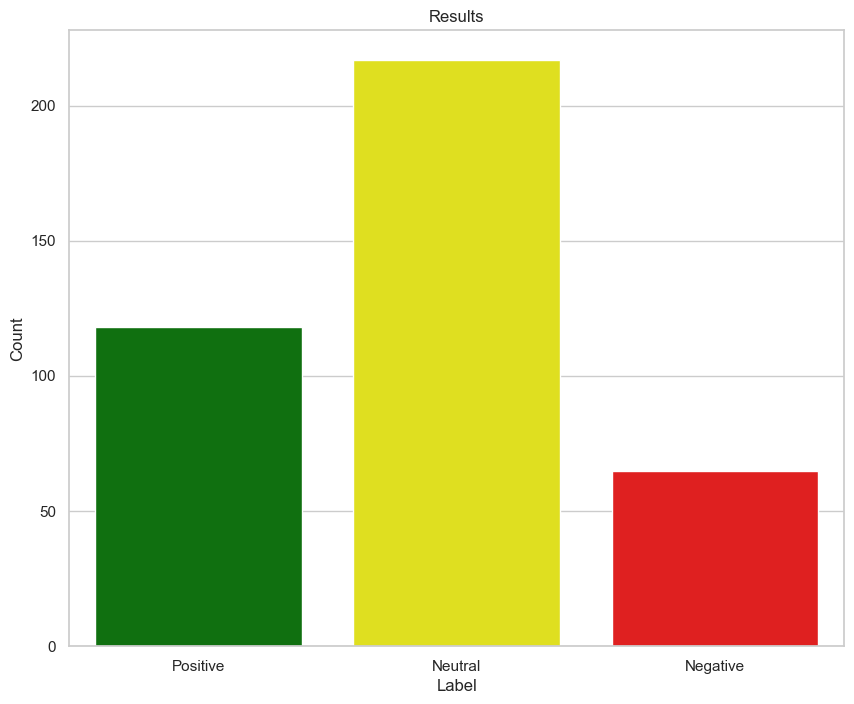

In [61]:
plot=sns.countplot(data=news2,x="label",order=['Positive','Neutral','Negative'],palette={'Positive':'g','Neutral':'yellow','Negative':'r'}).set(title='Results',ylabel='Count',xlabel='Label')

#sns.histplot(news.label)


In [63]:
#accuracy test
def news_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
news_sub = news.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
news_title_output(news_sub, "Positive")

print("\nNeutral news")
news_title_output(news_sub, "Neutral")

print("\nNegative news")
news_title_output(news_sub, "Negative")

Positive news
Top Venture Capitalist Shows Upside Setup Bitcoin (BTC) is Forming
Bitcoin Solo Miner Strikes Gold with 6.25 BTC Reward Worth $160,000
CZ himself said that “The day after the halving, the bitcoin price won’t double overnight. But the year after the halving, bitcoin price hits multiple ATHs.“ That‘s actually very true.
Mass Adoption is a Slow, But Steady Process. Webhost Company Accepts BTC with 30min Price Quotes. Your Thoughts?
Top 10 Most Expensive Things Bought with Bitcoin

Neutral news
Moving from a Culture of Crypto Volatility to Crypto Utility
I've discovered something concerning about Binance [SERIOUS2]
The Music of Bitcoin (only 19.99 BTC)
What is BTC’s next move? | Price Analysis
Bitcoin OGs Are Buying BTC At The Fastest Pace In 8 Years

Negative news
After the next halving, it's possible that you'll see some large scale miners shutting down. This is not to be taken as FUD, but a feature of the bitcoin blockchain. Explanation inside.
Crypto loss and psychology b

In [64]:
#Tokenization
text = "Texto Inicial ?'?'?''"
stop_words = stopwords.words('english')

In [65]:
#further preprocessing
def custom_tokenize(text):
  # remove single quote and dashes
  text = text.replace("'", "").replace("-", "").lower()

  # split on words only
  tk = nltk.tokenize.RegexpTokenizer(r'\w+')
  tokens = tk.tokenize(text)

  # remove stop words
  words = [w for w in tokens if not w in stop_words]
  return words

def tokens_2_words(df, label):
  # subset titles based on label
  titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
  tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
  words = list(chain.from_iterable(tokens))
  return words

pos_words = tokens_2_words(news, 'Positive')
neg_words = tokens_2_words(news, 'Negative')

In [85]:
#Visulaize tokens
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)
pprint(pos_freq.most_common(20))

[('bitcoin', 72),
 ('btc', 62),
 ('price', 20),
 ('000', 18),
 ('10', 15),
 ('top', 13),
 ('crypto', 11),
 ('etf', 10),
 ('worth', 8),
 ('profit', 8),
 ('years', 7),
 ('best', 7),
 ('6', 6),
 ('first', 6),
 ('spot', 5),
 ('million', 5),
 ('holding', 5),
 ('could', 5),
 ('ago', 5),
 ('today', 5)]


In [67]:
bitcoin_mask=np.array(Image.open('./c.png'))

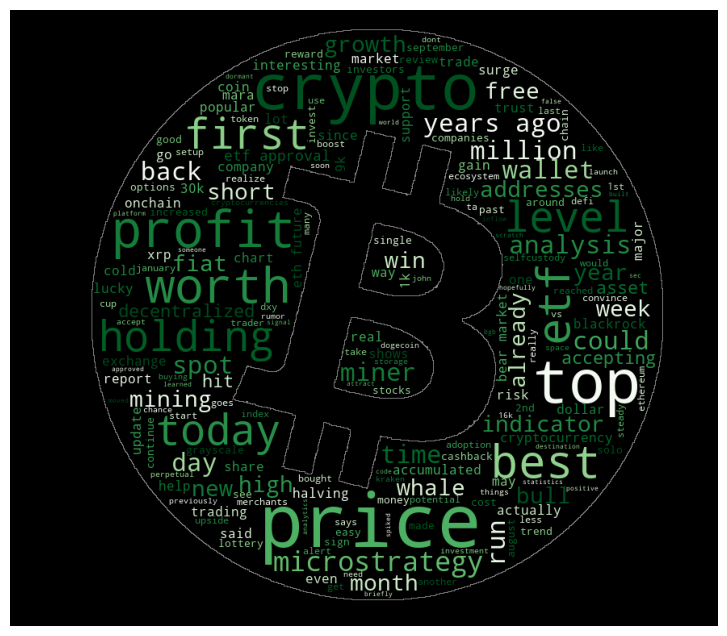

In [68]:
#Word Clouds
textpos=" ".join(pos_words)
wp = WordCloud(background_color='black', colormap = 'Greens_r',contour_color = 'grey',
               contour_width = 1,stopwords = ['Bitcoin','BTC'],
    mask=bitcoin_mask).generate(textpos)
plt.axis("off")
plt.imshow(wp)


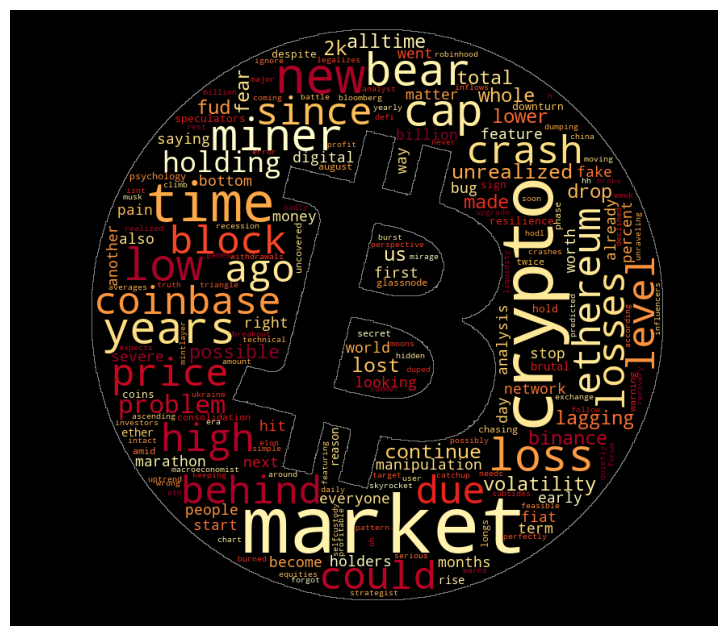

In [69]:
#Word Clouds
textneg=" ".join(neg_words)
wn = WordCloud(background_color='black', colormap = 'YlOrRd',mask=bitcoin_mask,contour_color = 'grey',
               contour_width = 1,stopwords = ['Bitcoin','BTC']
     ).generate(textneg)
plt.axis("off")
plt.imshow(wn)